---
# 1. Connecting to the Cloud PostgreSQL Database.
---

### 1. a) Importing required Libraries:-

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import psycopg2 as spg
from dotenv import load_dotenv
import matplotlib.pyplot as plt

### 1. b) Loading Database credentials from ***`.env `*** file:-

In [2]:
load_dotenv(dotenv_path=".env") # in case of multiple environments, it's better to mention the path
host_name = os.getenv("HOST_NAME")
db_name = os.getenv("DB_NAME")
port = os.getenv("PORT")
user_name = os.getenv("USER_NAME")
password = os.getenv("PASSWORD")

### 1. c) Connecting with Database and creating the ***`cursor()`*** :-

In [3]:
# Establishing connection.
try:
    connection = spg.connect(host=host_name, database=db_name, port=port, user=user_name, password=password)
except spg.OperationalError as error:
    raise error
else:
    print("Successfully connected to the PostgreSQL database!")

# Creating cursor.
cursor = connection.cursor()

Successfully connected to the PostgreSQL database!


---
# 2. Fetching data and assigning proper datatypes for memory efficiency.
---

### 2. a) Preparing short SQL query to select ***ALL except few columns*** of the database table:-
We have a total **29** columns in our table. Now, few of them ( ***5*** in this case ) is not required right now for the analysis purpose. So according to the traditional way, we would have to explicitly write ***24*** long column names in the **`SELECT`** statement. Which is definitely laborious. In order to efficiently writing the **`SELECT`** statement, the following workaround may be helpful. Or else, one can always follow the simple but laborious method of writing the query.

In [4]:
# Query to select desired column names of the table.
query =  '''SELECT STRING_AGG(COLUMN_NAME,',')
            FROM INFORMATION_SCHEMA.COLUMNS 
            WHERE 
            TABLE_SCHEMA = 'public' AND
            TABLE_NAME = 'yt_popular_videos' AND
            COLUMN_NAME NOT IN ('title','tags','category_id');'''

# Executing above query and storing the result.
cursor.execute(query)
columns = cursor.fetchone()[0]  # This syntax is for extracting only the string part, discarding all the wrappers of List and Tuple.
print(columns)

# Query to actually select required 24 columns from the table.
query = "SELECT "+columns+" FROM YT_POPULAR_VIDEOS ORDER BY ENTRY_TIMESTAMP DESC, RANK LIMIT 5000;"

rank,entry_timestamp,video_id,channel_name,channel_id,published_at,title_language,title_language_name,audio_language,audio_language_name,duration,quality,views,likes,dislikes,comments,live_start_real,live_end_real,live_start_scheduled,live_end_scheduled,live_viewers,cc,no_of_tags,embeddable,made_for_kids,topics


### 2. b) Reading the output of SQL query in a DataFrame:-

In [5]:
# Storing the output of the SQL query in a DataFrame.
df = pd.read_sql(query,connection)

#Closing the cursor and connection to the database.
cursor.close()
connection.close()

# Inspecting the DataFrame.
df.head()

,rank,entry_timestamp,video_id,channel_name,channel_id,published_at,title_language,title_language_name,audio_language,audio_language_name,...,live_start_real,live_end_real,live_start_scheduled,live_end_scheduled,live_viewers,cc,no_of_tags,embeddable,made_for_kids,topics
0,1,2021-09-23 16:24:27.424337+00:00,YjftfqRHAF4,Zee Studios,UC3jMepkLKF8y4iiwWmAB3RA,2021-09-22 04:29:31+00:00,None,None,en,English,...,NaT,NaT,NaT,None,None,True,NaN,True,False,"Entertainment, Film"
1,2,2021-09-23 16:24:27.424337+00:00,qIxVF77KIEs,We Are One,UCw5N06QIrXBg92OfOVpvWkg,2021-09-22 10:30:16+00:00,None,None,None,None,...,NaT,NaT,NaT,None,None,False,NaN,True,False,"Entertainment, Film"
2,3,2021-09-23 16:24:27.424337+00:00,xo4c_IzJV4I,Annapurna Studios,UCKA8af7IMMItFjqrYO9KgfQ,2021-09-23 04:38:00+00:00,en,English,te,Telugu,...,NaT,NaT,NaT,None,None,False,8.0,True,False,"Entertainment, Film"
3,4,2021-09-23 16:24:27.424337+00:00,oYBKM5-6tMw,Anshu Bisht Vlogs,UCrBV4KLmgBJ9CbOW5BpYTBA,2021-09-22 04:30:07+00:00,None,None,hi,Hindi,...,NaT,NaT,NaT,None,None,False,38.0,True,False,Lifestyle_(sociology)
4,5,2021-09-23 16:24:27.424337+00:00,Z0XLqjMwRLE,Sangeeth Kumar,UCdce_0JccaDtpuv5x9Gjdyw,2021-09-22 04:30:08+00:00,None,None,None,None,...,NaT,NaT,NaT,None,None,False,NaN,True,False,Lifestyle_(sociology)


### 2. c) Inspecting Datatypes and **deep memory usage** of DataFrame.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   rank                  1900 non-null   int64              
 1   entry_timestamp       1900 non-null   datetime64[ns, UTC]
 2   video_id              1900 non-null   object             
 3   channel_name          1900 non-null   object             
 4   channel_id            1900 non-null   object             
 5   published_at          1900 non-null   datetime64[ns, UTC]
 6   title_language        340 non-null    object             
 7   title_language_name   340 non-null    object             
 8   audio_language        1306 non-null   object             
 9   audio_language_name   1306 non-null   object             
 10  duration              1900 non-null   timedelta64[ns]    
 11  quality               1900 non-null   object             
 12  views 

In [7]:
memory_1 = round(df.memory_usage(deep=True).sum()/df.columns.size)
memory_1

48970

### 2. d) Converting datatypes.

1. Automatically converting column datatypes to best possible datatypes, supporting ***`pd.NA `***.

In [8]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   rank                  1900 non-null   Int64              
 1   entry_timestamp       1900 non-null   datetime64[ns, UTC]
 2   video_id              1900 non-null   string             
 3   channel_name          1900 non-null   string             
 4   channel_id            1900 non-null   string             
 5   published_at          1900 non-null   datetime64[ns, UTC]
 6   title_language        340 non-null    string             
 7   title_language_name   340 non-null    string             
 8   audio_language        1306 non-null   string             
 9   audio_language_name   1306 non-null   string             
 10  duration              1900 non-null   float64            
 11  quality               1900 non-null   string             
 12  views 

2. Modifying the ***`Integer`*** datatypes to **memory-efficient** integer datatypes.

In [9]:
df["no_of_tags"] = df["no_of_tags"].astype("UInt16")

3. Parsing **Duration** column as python ***`datetime.timedelta`*** object type from ***`float64`*** datatype.

In [10]:
df["duration"] = df["duration"].apply(pd.Timedelta)

4. Converting applicable columns ( e.g.- **quality**, **audio_language** ) to memory efficient ***`categorical`*** datatype.

In [11]:
cols = ["rank","video_id","channel_id","quality"]
df[cols] = df[cols].astype("category")
df.loc[:,"title_language":"audio_language_name"] = df.loc[:,"title_language":"audio_language_name"].astype("category")

5. Dropping columns having all **`NULL`** values.

In [12]:
df.drop(columns=["live_end_scheduled","live_viewers"],inplace=True)

6. Noting down the average **data usage** per column of the final, processed DataFrame.

In [13]:
memory_2 = round(df.memory_usage(deep=True).sum()/df.columns.size)
memory_2

24659

### 2. e) Calculating **memory efficiency** obtained by processing the DataFrame:-

In [14]:
memory_efficiency = round((memory_1-memory_2)*100/memory_1)
print(f"----- Total memory usage is reduced by {memory_efficiency}% -----")

----- Total memory usage is reduced by 50% -----


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   rank                  1900 non-null   category           
 1   entry_timestamp       1900 non-null   datetime64[ns, UTC]
 2   video_id              1900 non-null   category           
 3   channel_name          1900 non-null   string             
 4   channel_id            1900 non-null   category           
 5   published_at          1900 non-null   datetime64[ns, UTC]
 6   title_language        340 non-null    category           
 7   title_language_name   340 non-null    category           
 8   audio_language        1306 non-null   category           
 9   audio_language_name   1306 non-null   category           
 10  duration              1900 non-null   timedelta64[ns]    
 11  quality               1900 non-null   category           
 12  views 

---
# 3. Performing **Data Analysis & Visualization**.
---

### 3. a) Understanding the ratio of popular **Live-Streamed** content vs popular **Posted** Videos:-

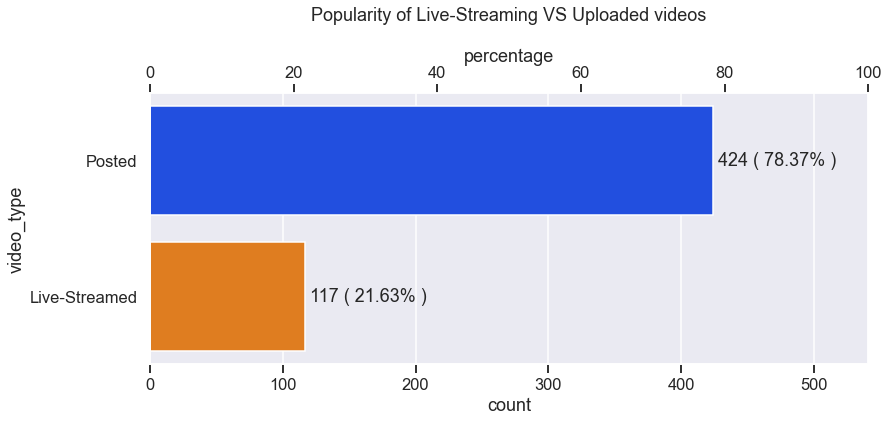

In [16]:
df["video_type"] = np.where((df.live_start_real.notnull() | df.live_start_scheduled.notnull() ),
                            "Live-Streamed","Posted")
df["video_type"] = df["video_type"].astype("category")
df_uvid = df.drop_duplicates(subset="video_id")

dfa1 = pd.DataFrame(
    (df_uvid[["video_type"]].value_counts(normalize=True).mul(100).rename("percentage"),
    df_uvid[["video_type"]].value_counts().rename("count"))).T.reset_index()
n = df_uvid.video_type.size

sns.set_theme(context="talk",palette="bright")

ga1 = sns.catplot(data=dfa1,y="video_type",x="count",
                  kind="bar",order = dfa1["video_type"], aspect=2.5,ci=None)
plt.title("Popularity of Live-Streaming VS Uploaded videos")
ga1.ax.set_xlim(0,n)
ga2 = ga1.ax.twiny()
ga2.set_xlabel("\npercentage")
ga2.set_xlim(0,100)
ga2.grid(None)
for p in ga1.ax.patches:
    x = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    ga1.ax.annotate(f" {int(x)} ( {round(100*x/n,2)}% )",(x, y.mean()),va="center")

#### So as we can see from the above figure, in India, currently majority of popular videos are uploaded videos. But we still have >20% of popular videos as Live Streaming content which is not bad considering live streams are much longer and it is unlikely that people will watch live streamed content after the stream is over. So, attracting viewers in such tight span of time is harder whereas a normal uploaded video offers a lot more flexibility to the viewers regarding the time of watching. Also, difference in data consumption may be a factor for such statistics ( ratio > 1:4 ).

### 3. b) Understanding the video qualities. How many "**sd**" quality videos are popular?

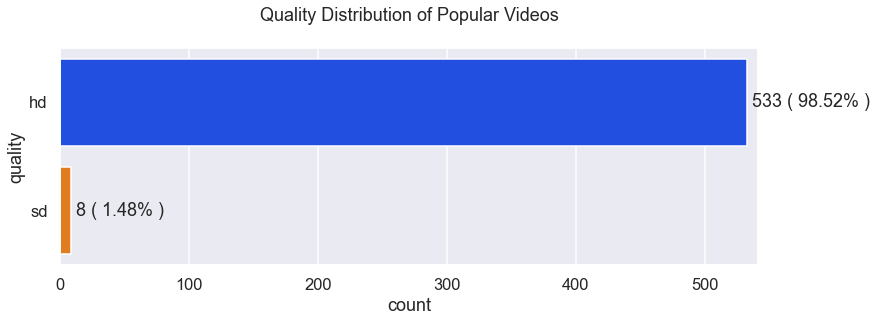

In [17]:
gb1 = sns.countplot(y="quality",data=df_uvid[["quality"]])
plt.title("Quality Distribution of Popular Videos\n")
gb1.figure.set_figwidth(12.5)
gb1.set_xlim(0,n)
for p in gb1.patches:
    x = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    gb1.annotate(f" {int(x)} ( {round(100*x/n,2)}% )",(x, y.mean()),va="center")

In [18]:
df_uvid[df["quality"]=="sd"]

C:\Users\Anik\AppData\Local\Temp/ipykernel_3980/366253204.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_uvid[df["quality"]=="sd"]


,rank,entry_timestamp,video_id,channel_name,channel_id,published_at,title_language,title_language_name,audio_language,audio_language_name,...,comments,live_start_real,live_end_real,live_start_scheduled,cc,no_of_tags,embeddable,made_for_kids,topics,video_type
40,41,2021-09-23 16:24:27.424337+00:00,6bEE6ZiRk-4,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-22 17:29:52+00:00,NaN,NaN,hi,Hindi,...,7,2021-09-22 01:15:50+00:00,2021-09-22 16:02:42+00:00,NaT,False,28,True,False,Society,Live-Streamed
258,59,2021-09-22 21:15:06.292804+00:00,iFH0hoPmYaM,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-21 10:49:34+00:00,NaN,NaN,hi,Hindi,...,3,2021-09-21 01:24:49+00:00,2021-09-21 10:05:51+00:00,NaT,False,28,True,False,Society,Live-Streamed
472,73,2021-09-22 03:13:47.481597+00:00,-Ep0cgeyRTI,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-20 11:21:20+00:00,NaN,NaN,hi,Hindi,...,9,2021-09-20 01:25:28+00:00,2021-09-20 10:23:13+00:00,NaT,False,28,True,False,Society,Live-Streamed
877,78,2021-09-20 01:19:45.128365+00:00,XhnW0vWvoUY,Sandesh News,UCiAH2s_M6nPfGZk-PpfyPkg,2021-09-16 07:22:33+00:00,NaN,NaN,gu,Gujarati,...,<NA>,2021-09-16 07:22:46+00:00,2021-09-18 22:44:10+00:00,NaT,False,26,True,False,Society,Live-Streamed
1167,68,2021-09-17 21:54:03.357295+00:00,7M2FwAXgStM,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-16 11:12:12+00:00,NaN,NaN,hi,Hindi,...,6,2021-09-16 01:25:49+00:00,2021-09-16 10:12:37+00:00,NaT,False,28,True,False,Society,Live-Streamed
1188,89,2021-09-17 21:54:03.357295+00:00,eLf2zIfUX64,Kanak News,UC90RW5ZmBBqp4r2QIQxfACA,2021-09-14 13:31:55+00:00,or,Odia,or,Odia,...,273,NaT,NaT,NaT,False,24,True,False,Society,Posted
1456,57,2021-09-16 16:08:31.790900+00:00,PIz0oGeHzcM,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-15 10:51:05+00:00,NaN,NaN,hi,Hindi,...,1,2021-09-15 01:24:49+00:00,2021-09-15 10:11:23+00:00,NaT,False,28,True,False,Society,Live-Streamed
1590,91,2021-09-16 07:07:23.093055+00:00,BLQc2_kGtPk,Zee Business,UCkXopQ3ubd-rnXnStZqCl2w,2021-09-14 10:37:37+00:00,NaN,NaN,hi,Hindi,...,7,2021-09-14 01:35:09+00:00,2021-09-14 10:09:37+00:00,NaT,False,29,True,False,Society,Live-Streamed


#### As it is clear from the above figure that India predominantly produces and consumes *HD* ( >=720p ) videos only. With the super cheap data in the whole world, such statistics ( **98% +** HD videos ) is expected. Also thanks to the creators for using quality tech tools. Although tiny, ~ 1.5% of popular videos are found to be of SD quality ( 360p / 480p ).

### 3. c) Understanding the duration distribution of popular videos including ***YouTube Shorts*** ( <=60 secs ):-

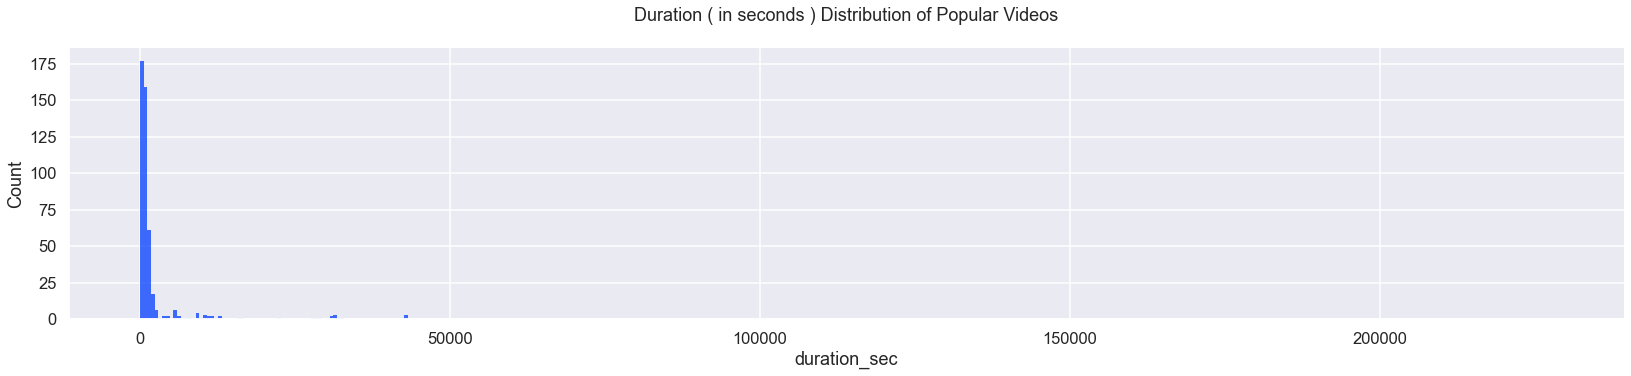

In [19]:
a = df_uvid.duration.dt.total_seconds().astype("int")
df_uvid.insert(df_uvid.columns.size,"duration_sec",a)
bins = [0, 60]+[i for i in np.arange(600,a.max(),600)]

gc1 = sns.displot(df_uvid,x="duration_sec",bins=bins)
plt.title("Duration ( in seconds ) Distribution of Popular Videos\n")
gc1.figure.set_figwidth(30)

In [20]:
# As the histogram shows that the durations are heavily skewed, it will be better to divide videos into categories based on duration and then analyze individually in different scales.
df_uvid["duration_tag"] = np.where(df_uvid["duration_sec"] <=60,"Shorts",(np.where(df_uvid["duration_sec"] <=1800,"Normal","Long")))
tag_order = df_uvid.duration_tag.value_counts().index

C:\Users\Anik\AppData\Local\Temp/ipykernel_3980/3828289926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uvid["duration_tag"] = np.where(df_uvid["duration_sec"] <=60,"Shorts",(np.where(df_uvid["duration_sec"] <=1800,"Normal","Long")))


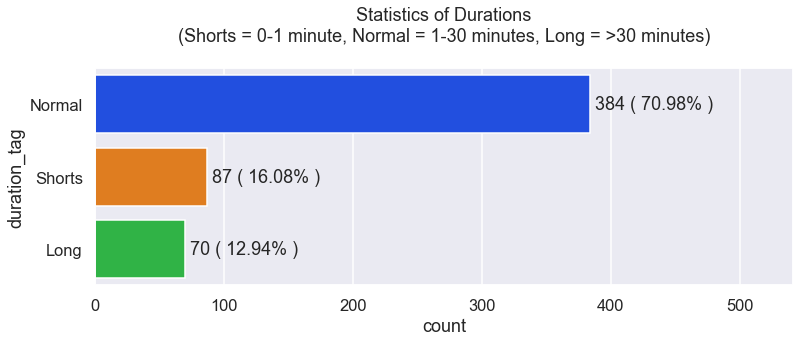

In [21]:
gc2 = sns.countplot(data=df_uvid,y="duration_tag",order=tag_order)
plt.title("Statistics of Durations\n(Shorts = 0-1 minute, Normal = 1-30 minutes, Long = >30 minutes)\n")

n = len(df_uvid.duration_tag)
gc2.set_xlim(0,n)
gc2.figure.set_figwidth(12.5)
for p in gc2.patches:
    x = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    gc2.annotate(f" {int(x)} ( {round(100*x/n,2)}% )",(x, y.mean()),va="center")

Text(0.5, 1.2, 'Analysis of Popular Video durations ( in seconds )')

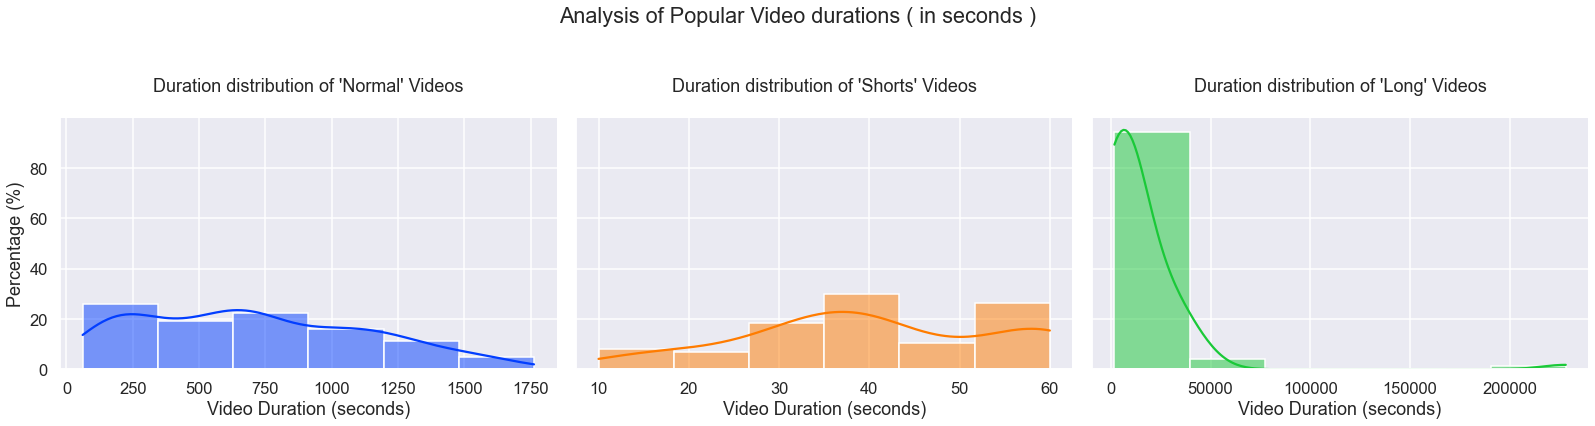

In [22]:
gc3 = sns.FacetGrid(df_uvid,col="duration_tag",sharex=False,height=5,aspect=1.5,col_wrap=3,col_order=tag_order,hue="duration_tag")
gc3.map_dataframe(sns.histplot,x="duration_sec",kde=True,bins=6,stat="percent")
gc3.set_axis_labels("Video Duration (seconds)","Percentage (%)")
gc3.set_titles(col_template="Duration distribution of '{col_name}' Videos\n")
gc3.figure.suptitle("Analysis of Popular Video durations ( in seconds )",y=1.2)

#### So analyzing the distribution of popular videos, it can be inferred that, the newly added feature ***YouTube Shorts*** is doing quite well. It is more popular than *Long* ( length: > 30 minute ) videos. But, the most popular category is *Normal* ( length: 1 - 30 minute ) videos, occupying ~ 70% of all popular videos.</br>Again, analyzing individual categories, we found that *Normal* videos of all durations are equally popular with slight inclination towards smaller duration ones. Whereas ***Shorts*** of 35 seconds & 55 seconds are the most popular within its category. Lastly, in case of *Long* videos, ~ 5000 seconds / 1 hour 25 minutes videos are predominantly popular. Surprisingly, ~ 8 hour 20 minutes long videos are the 2nd most popular videos in *Long* videos.

### 3. d) Analyzing the stats of Languages:-

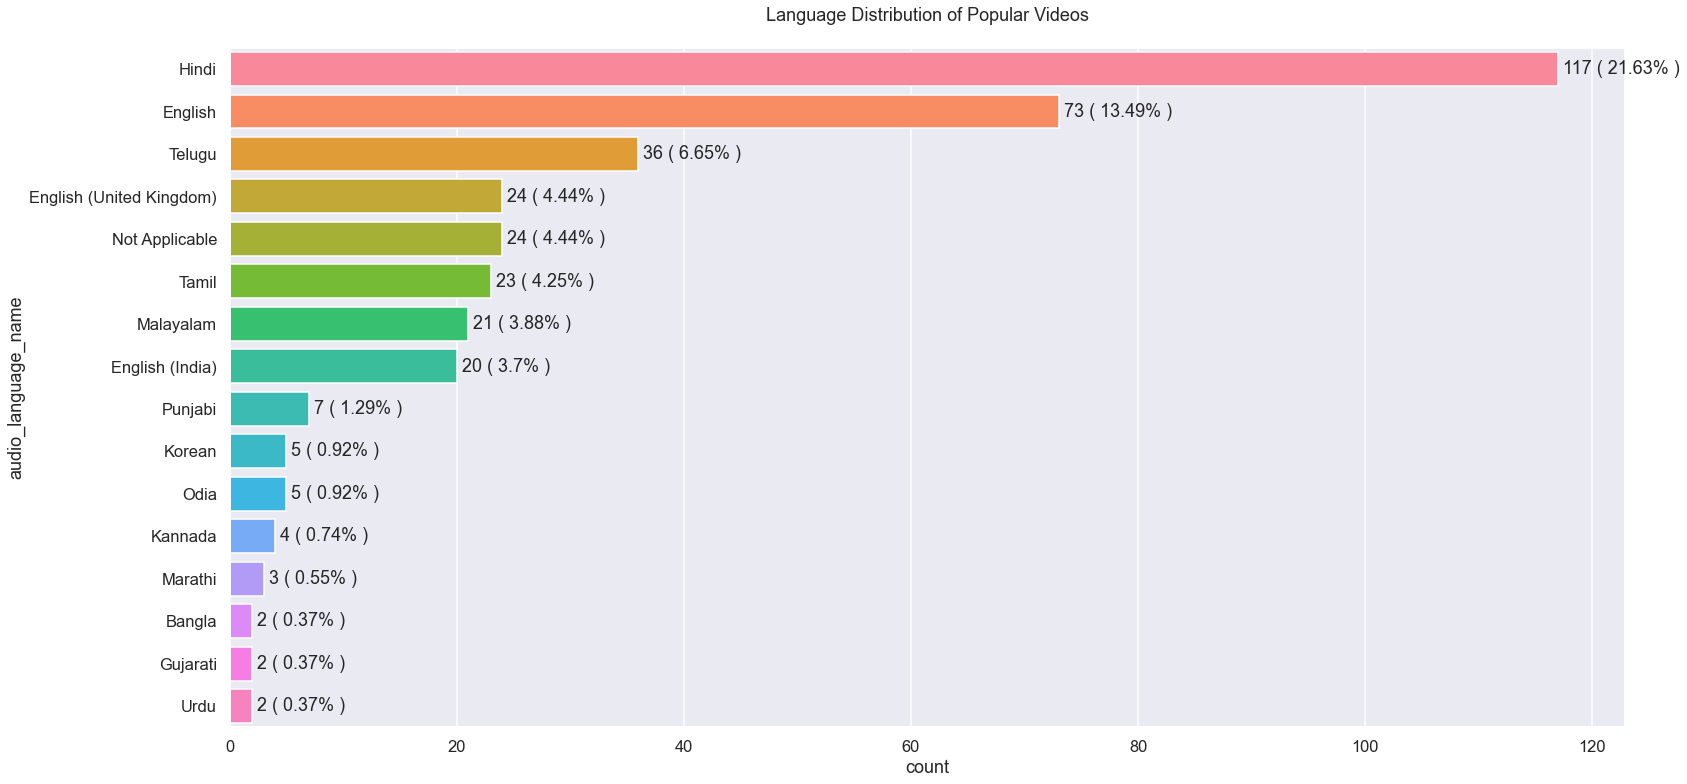

In [23]:
gd1 = sns.countplot(data=df_uvid,y="audio_language_name",order=df_uvid.audio_language_name.value_counts().index,saturation=1)
plt.title("Language Distribution of Popular Videos\n")
gd1.figure.set_figwidth(25)
gd1.figure.set_figheight(12.5)

for p in gd1.patches:
    x = p.get_bbox().get_points()[1,0]
    y = p.get_bbox().get_points()[:,1]
    gd1.annotate(f" {int(x)} ( {round(100*x/n,2)}% )",(x, y.mean()),va="center")


#### The two *Official Languages* ( **Hindi** & **English** ) of India are the most favoured languages for the popular YouTube videos. Though it may seem **Hindi** has the highest popularity, surpassing **English**, it is not correct. Due to the fact that there are 3 kinds of **English** listed in the YouTube's official list of languages, **English's** actual count got divided and in reality, after adding those up, we will get **English** as the clear winner. Also, there is some usage of **local** indian languages that are **not** listed in the YouTube's dictionary of valid languages. Surprisingly ***Korean*** is quite popular in India! Maybe the effect of new music video launched.

### 3. e) Correlation analysis of Views, Likes, Dislikes etc. :-

In [24]:
round(df_uvid.describe())

,duration,views,likes,dislikes,comments,no_of_tags,duration_sec
count,541,541.0,540.0,540.0,533.0,440.0,541.0
mean,0 days 00:39:42.255083179,3051674.0,183796.0,4982.0,11576.0,20.0,2382.0
std,0 days 03:06:27.406369961,8660375.0,583799.0,13532.0,104825.0,10.0,11187.0
min,0 days 00:00:10,38158.0,843.0,53.0,0.0,1.0,10.0
25%,0 days 00:03:03,362293.0,17114.0,449.0,506.0,12.0,183.0
50%,0 days 00:10:44,944189.0,55598.0,1378.0,1564.0,20.0,644.0
75%,0 days 00:19:41,2524370.0,154909.0,4071.0,6067.0,25.0,1181.0
max,2 days 15:21:23,147479847.0,11196250.0,211284.0,2383024.0,60.0,228083.0


Text(0.5, 1.05, 'Correlation analysis of engagement metrices using Scatter Plot')

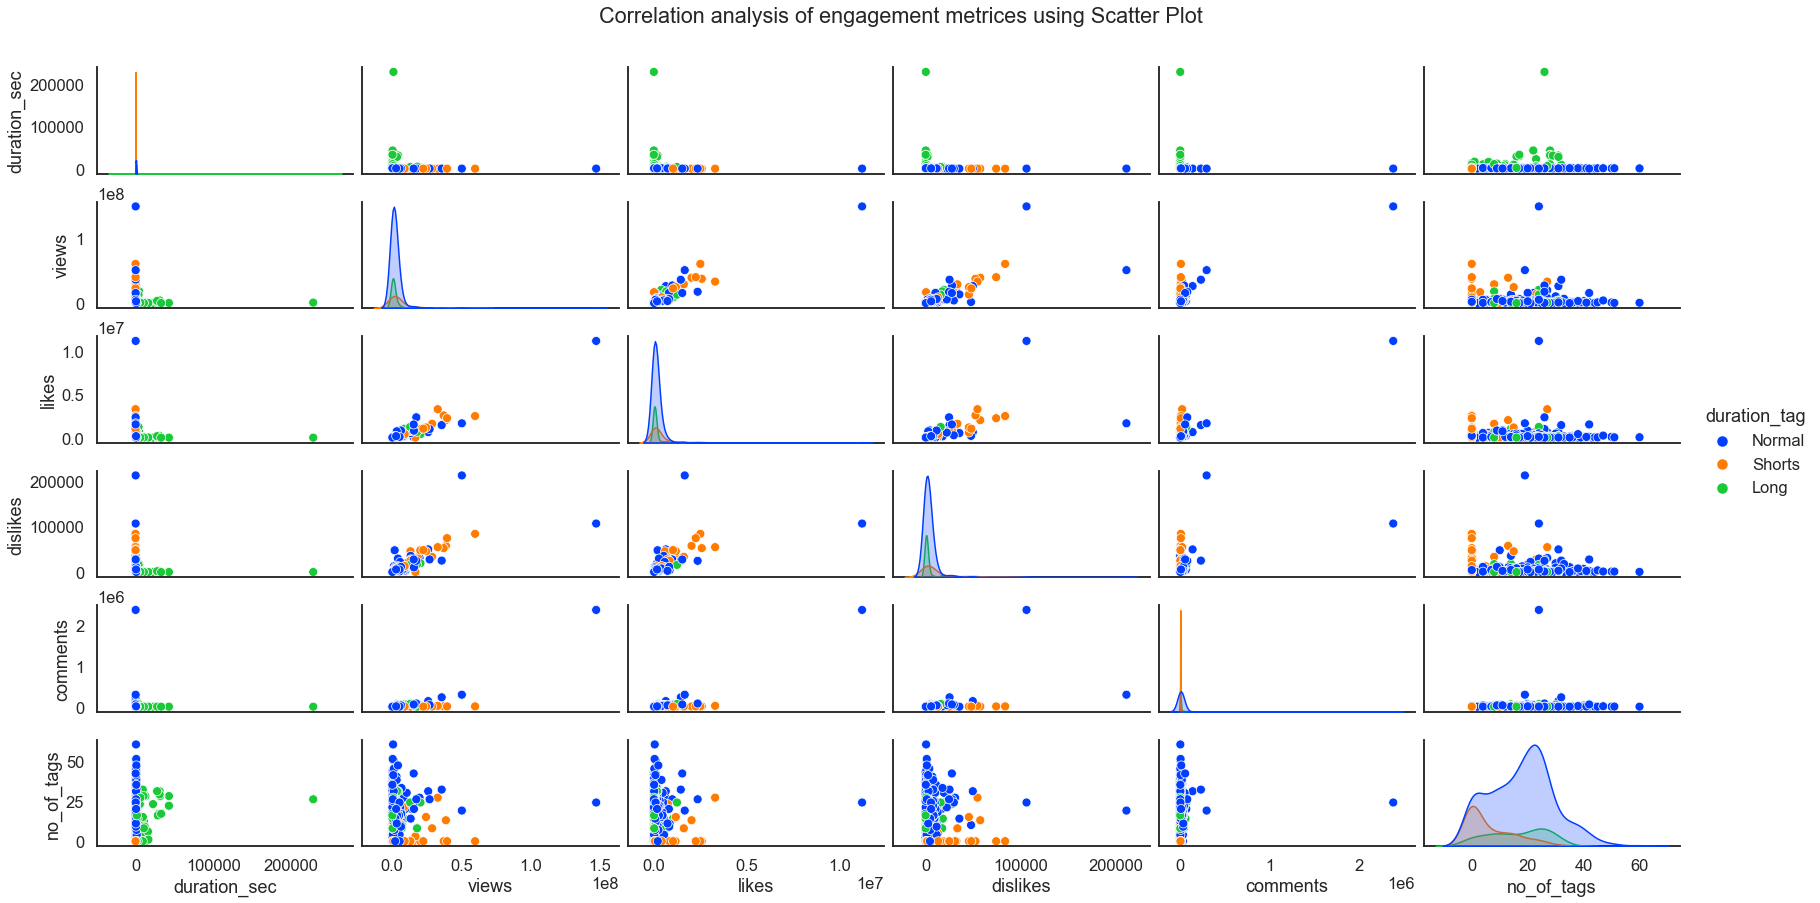

In [25]:
sns.set_theme(context="talk",style="white",palette="bright")

cols = ["duration_sec","views","likes","dislikes","comments","no_of_tags","duration_tag"]
a = df_uvid[cols].fillna(0).astype("float",errors="ignore")
order = a.duration_tag.value_counts().index

ge1 = sns.pairplot(data=a,height=2,aspect=2,hue="duration_tag",hue_order=tag_order)
ge1.fig.suptitle("Correlation analysis of engagement metrices using Scatter Plot",y=1.05)

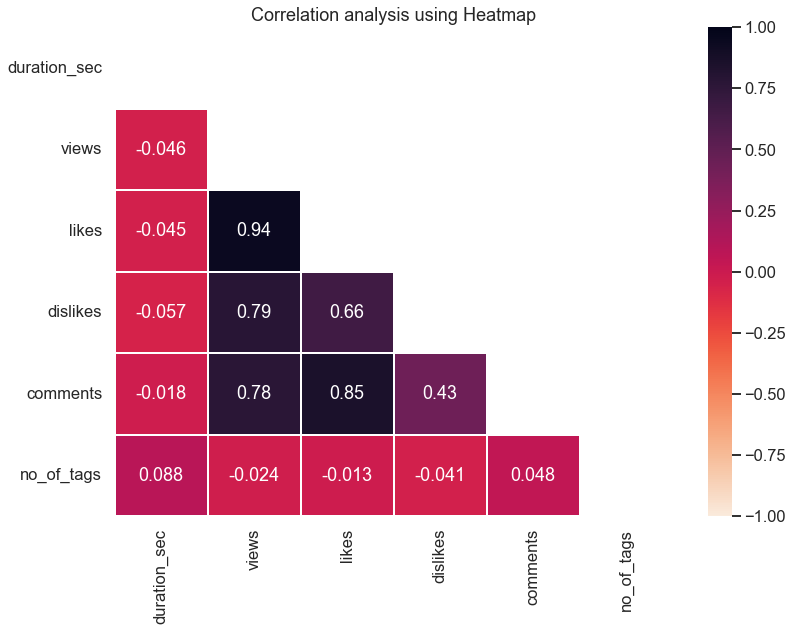

In [26]:
mask = np.triu(np.ones_like(a.corr(), dtype=bool))
ge2 = sns.heatmap(data=a.corr(),linewidths=1,vmin=-1.0,vmax=1.0,annot=True,mask=mask,cmap="rocket_r")
ge2.figure.set_figwidth(12.5)
plt.title("Correlation analysis using Heatmap")
ge2.figure.set_figheight(9)

#### As we can see from above 2 charts, in our sample, number of likes, comments and dislikes of any video are highly correlated ( +ve ) with the number of views that video got with correlation coefficient values in the respective order. Another fact obtained is that, comments have high positive correlation with likes. So more the people like a video, more is the chance that they leave some comment also. It is also clear that no_of_tags and duration of the video have no impact on the audience engagement as they have nearly 0 correlation coefficient with all other variables. But, in case of *Long* type of videos, they are highly correlated to each other.</br>Interestingly it appears that, we have a good correlation between dislikes and likes. But this is a pitfall of the correlation method. As we know, one can only like or dislike a particular video and not both, the coefficient value here makes no sense and their high correlation is actually a result of their individual high positive correlation with a common variable; *views*.

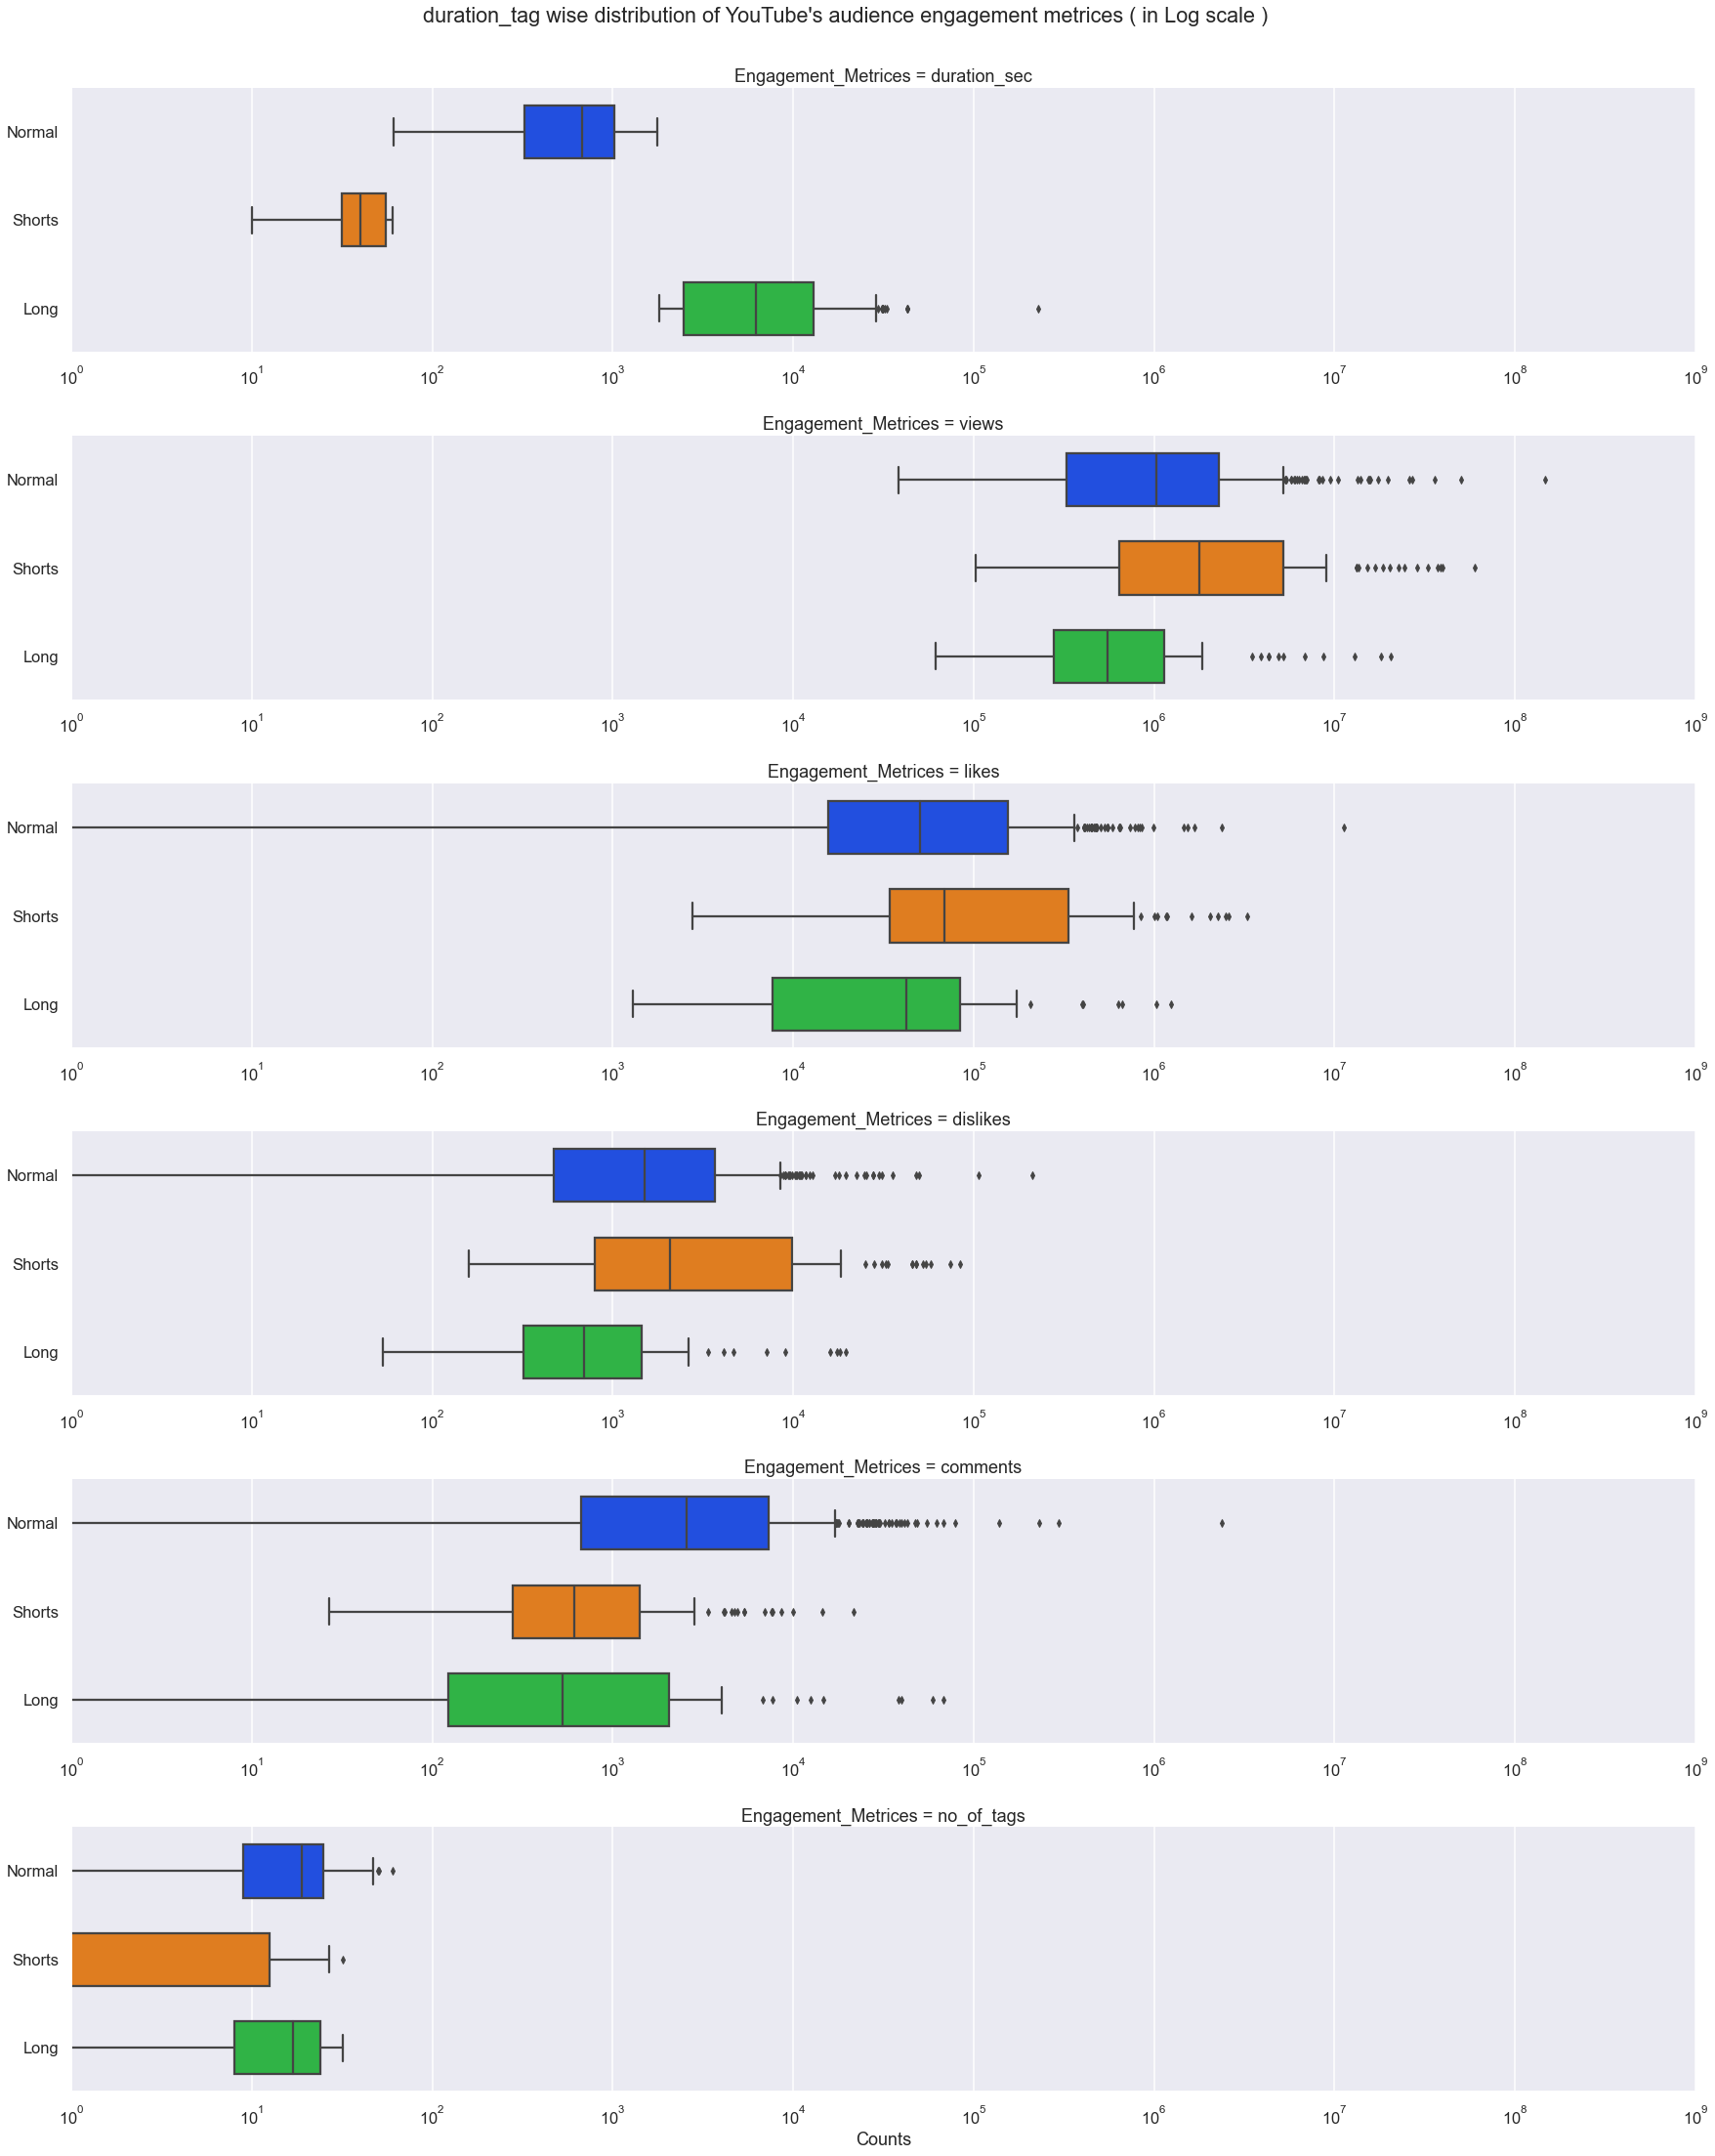

In [27]:
sns.set_theme(context="talk",palette="bright")

b = a.melt(id_vars="duration_tag",var_name="Engagement_Metrices",value_name="Counts")
ge3 = sns.catplot(data=b,x="Counts",y="duration_tag",row="Engagement_Metrices",kind="box",aspect=5,order=tag_order,width=.6,sharex=False)
ge3.set(xscale="log",xticks=[10**i for i in range(10)])

ge3.figure.suptitle("duration_tag wise distribution of YouTube's audience engagement metrices ( in Log scale )",y=1.02)
ge3.set_ylabels("")

# ALTERNATE WAY WITHOUT MELTING THE DATAFRAME.
# n = len(a.columns)-1
# fig,axes = plt.subplots(nrows=n,ncols=1,sharex=True)
# for col,i in zip(a.drop(columns="duration_tag").columns,range(n)):
#     ge3 = sns.boxplot(data=a,x=col,y="duration_tag",order=tag_order,ax=axes[i])
#     ge3.set_xscale("log")
#     ge3.grid(b=True,axis="x",which="minor")
#     ge3.tick_params(axis="x",which="minor",color="m")

#### We can infer that, 50% of the popular *Normal* and *Shorts* video will have more than a *Million* views. And views of a *Short* video is generally higher than other video types. Also, approximately, <ul><li>no. of likes in a video is 5% of its views,</li><li>no. of dislikes is 5% of its likes,</li><li>no. of comments = no. of dislikes (not for *Shorts*)</li></ul>

In [38]:
# Check for non-zero values before dividing with it.
a_sub = a[(a.views!=0)&(a.likes!=0)&(a.dislikes!=0)].assign(likes_views = round(100*a["likes"]/a["views"],2),
         dislikes_likes = round(100*a["dislikes"]/a["likes"],2),
         comments_dislikes = round(100*a["comments"]/a["dislikes"],2)
        )

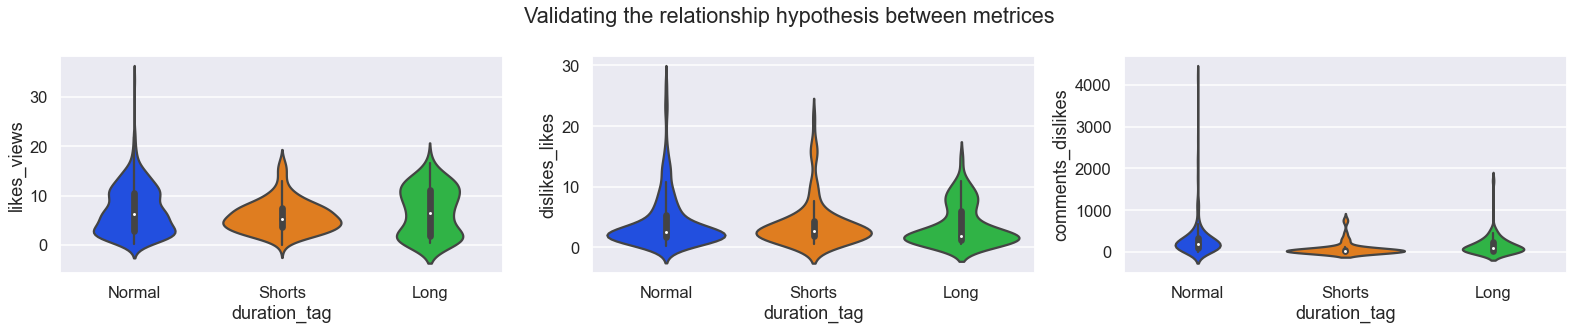

In [43]:
a_sub = a_sub.loc[:,"duration_tag":]

n = len(a_sub.columns)-1
fig,axes = plt.subplots(nrows=1,ncols=n,)
col = ["likes_views","dislikes_views","comments_dislikes"]

for col,i in zip(a_sub.drop(columns="duration_tag").columns,range(n)):
    ge4 = sns.violinplot(data=a_sub,y=col,x="duration_tag",order=tag_order,ax=axes[i])

ge4.figure.suptitle("Validating the relationship hypothesis between metrices",y=1.05)
ge4.grid(b=True,axis="y",which="minor")
ge4.tick_params(axis="y",which="minor",color="m")    

fig.set_figwidth(27)

In [45]:
round(a_sub.describe())

,likes_views,dislikes_likes,comments_dislikes
count,540.0,540.0,540.0
mean,7.0,4.0,246.0
std,5.0,4.0,400.0
min,0.0,0.0,0.0
25%,3.0,2.0,45.0
50%,6.0,2.0,153.0
75%,10.0,5.0,293.0
max,33.0,27.0,4194.0


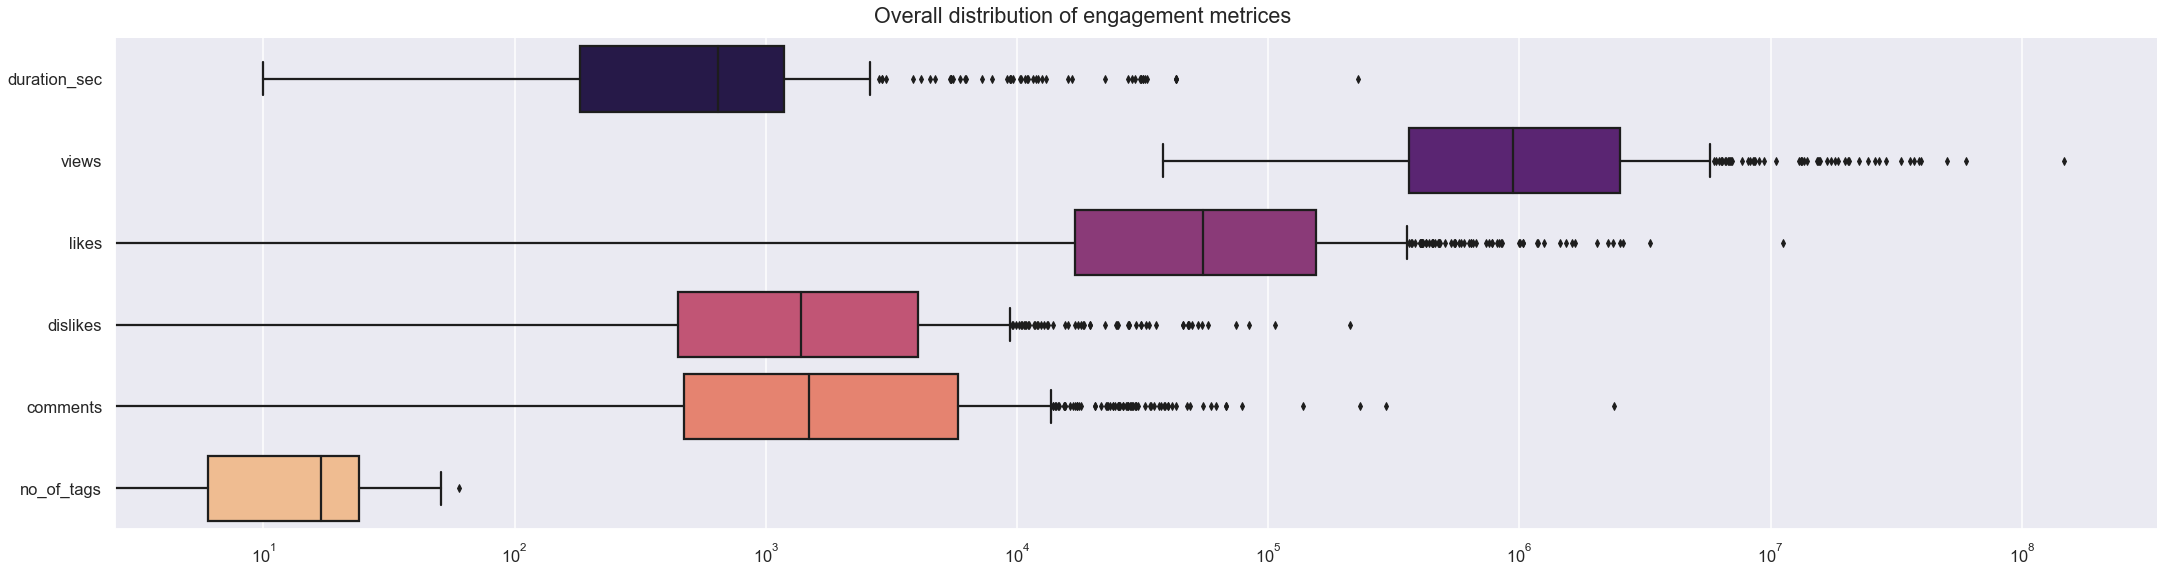

In [46]:
ge5 = sns.catplot(data=a,orient="h",kind="box",sharex=False,height=8,aspect=3.8,palette="magma")
ge5.figure.suptitle("Overall distribution of engagement metrices",y=1.02)
ge5.ax.set_xscale("log")

#### So, as we can see from above figures, our rough estimation of approximate relationship between the *views*, *likes*, and *dislikes* of a popular YouTube video is acceptable. However the hypothesis of *comments-dislikes* relation seems not valid and the reason may be the ***Giveaways*** or any kind of direction from the content creator that influences the natural behavior. 

### 3. f) Understanding the video posting / live-streaming timing in local times:-

In [47]:
c = df_uvid[["duration_tag","published_at","live_start_scheduled","live_start_real"]].fillna(pd.Timestamp.min.tz_localize("UTC"))
c["local_publish_time"] = np.maximum(c.published_at,np.maximum(c.live_start_scheduled, c.live_start_real)).dt.tz_convert('Asia/Kolkata').dt.hour
c = c[["duration_tag","local_publish_time"]]

Text(0.5, 1.02, 'Analysis of peak hour for uploading videos')

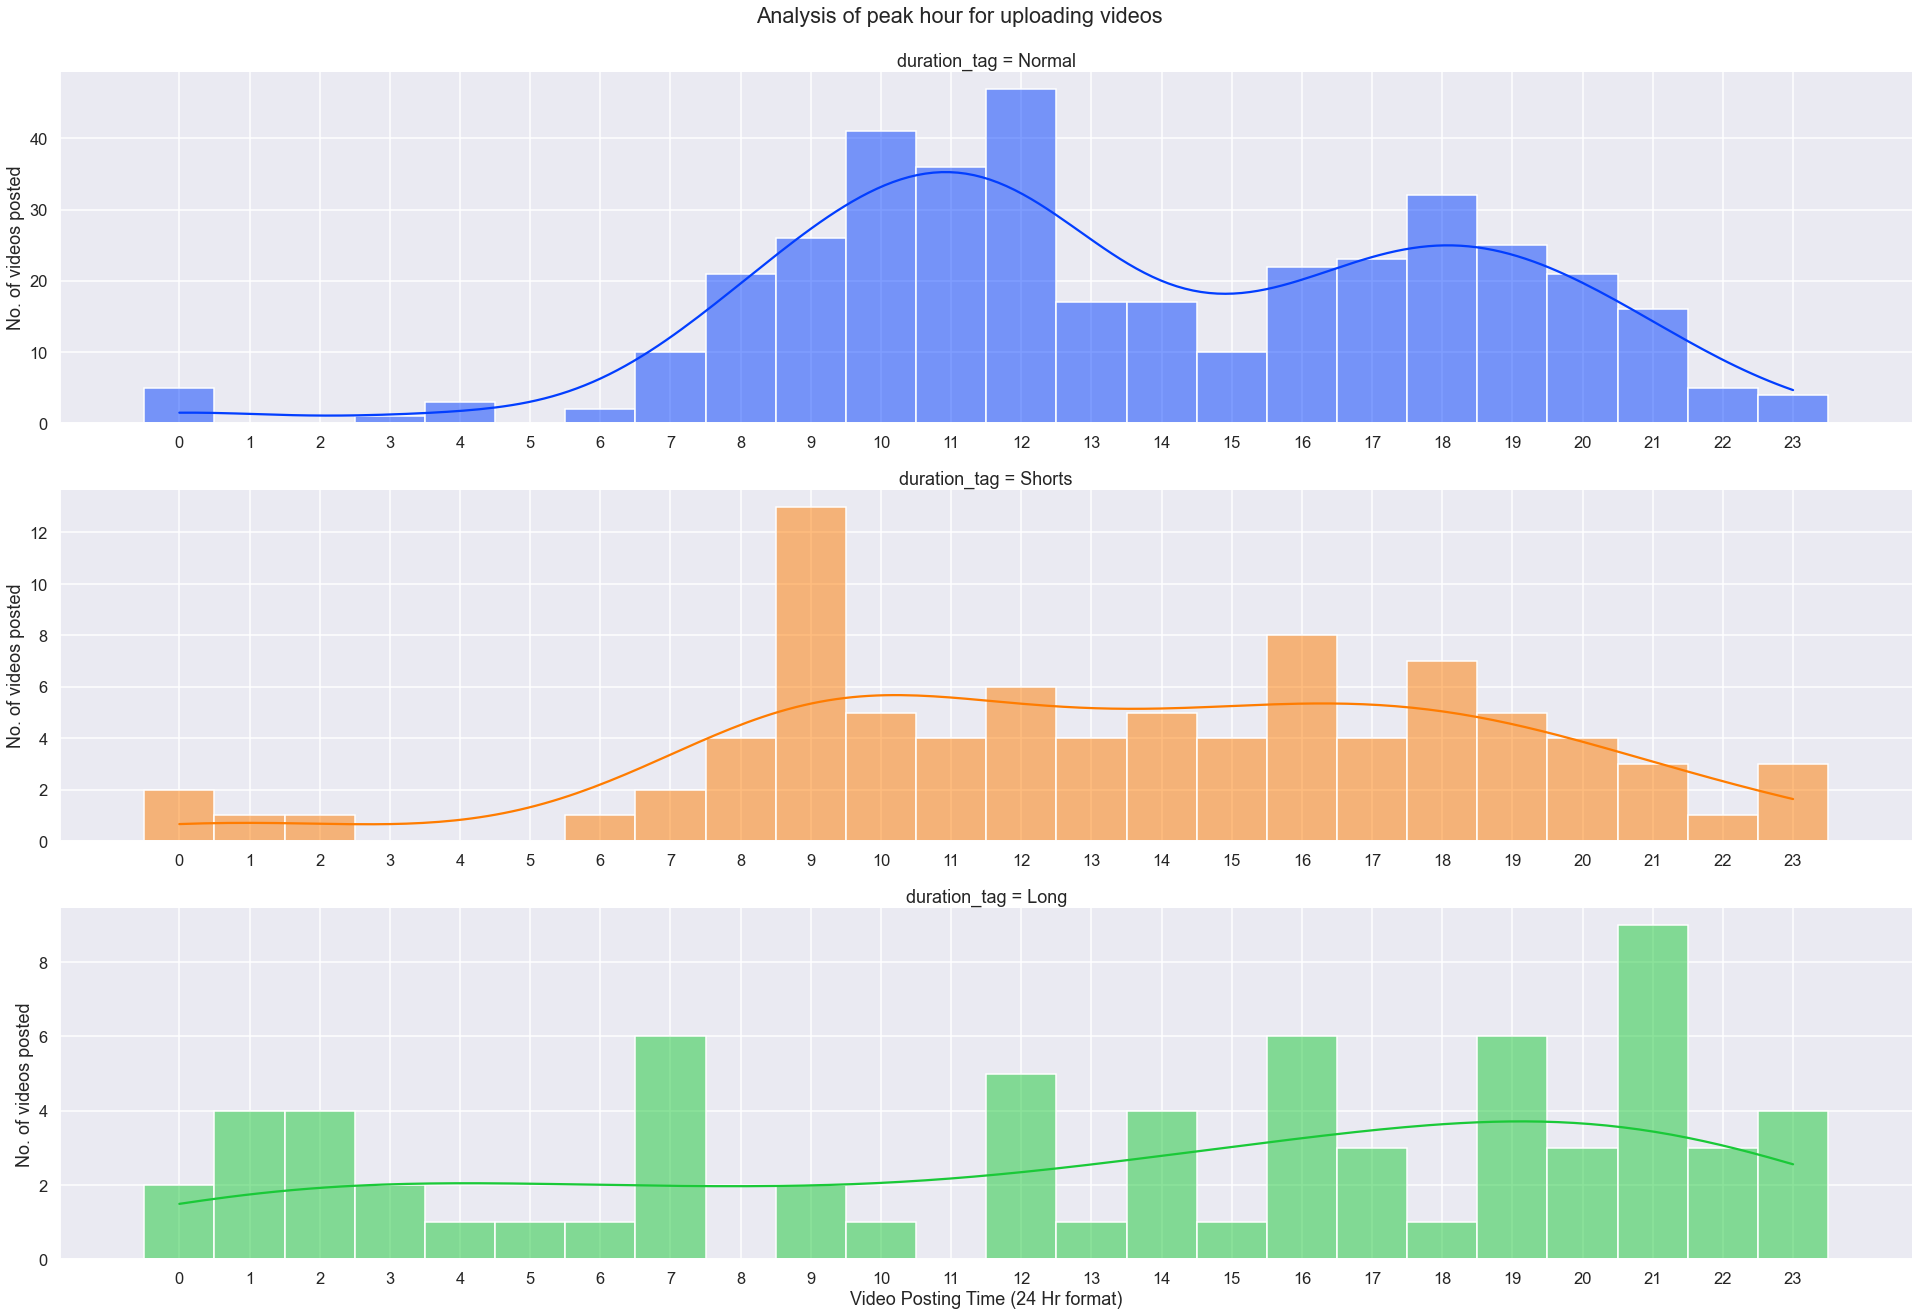

In [48]:
gf1 = sns.FacetGrid(c,row="duration_tag",height=6,aspect=4.5,row_order=tag_order,hue="duration_tag",sharey=False,sharex=False)
gf1.map_dataframe(sns.histplot,x="local_publish_time",kde=True,discrete=True)
gf1.set_axis_labels("Video Posting Time (24 Hr format)","No. of videos posted")
gf1.set_titles(col_template="Publish times of '{col_name}' Videos\n")
gf1.set(xticks=[i for i in range(24)])
gf1.figure.suptitle("Analysis of peak hour for uploading videos",y=1.02)

#### So we can see that the *peak hour* for uploading video varies according to the video *duration_tag*. For *Normal* videos, it is 10 am in the morning to 12 pm. It also increases at the 6-7 pm range. But for *Shorts*, it is around 9 am and 4 pm in the afternoon. *Long* videos are mostly published at 9 pm in the night.